In [86]:
# Read unfiltered water-level data; compare with model\
import glob, os
import pandas as pd
import numpy as np
import xarray as xr
import xroms
import matplotlib.pyplot as plt
from scipy import stats
import hvplot.xarray

# These files were downloaded from https://stn.wim.usgs.gov/fev/ on 1/19/2023
data_dir = r'/vortexfs1/home/csherwood/proj/NOPP_Michael/data/'
hwm_file = 'Michael_FilteredHWMs.csv'
peaks_file = 'Michael_FilteredPeaks.csv'

# url='http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Michael2018/michael20/michael20.ncml'
# url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Michael2018/michael33/qck/michael_qck.ncml'
url = 'http://geoport.whoi.edu/thredds/dodsC/vortexfs1/usgs/Projects/Michael2018/michael37/qck/michael_qck.ncml'

# Based on datum for 8729108 Panama City, FL
MSLtoNAVD88 = -0.11 # (m) Add this offset to convert model output (MSL) to gauge output (NAVD88)

In [87]:
dsm=xroms.open_netcdf(url)
dsm

<xarray.Dataset>
Dimensions:          (tracer: 2, boundary: 4, s_rho: 12, s_w: 13, eta_rho: 587,
                      xi_rho: 317, xi_u: 316, eta_v: 586, ocean_time: 109)
Coordinates: (12/31)
  * s_rho            (s_rho) float64 -0.9583 -0.875 -0.7917 ... -0.125 -0.04167
  * s_w              (s_w) float64 -1.0 -0.9167 -0.8333 ... -0.1667 -0.08333 0.0
    lon_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(587, 317), meta=np.ndarray>
    lat_rho          (eta_rho, xi_rho) float64 dask.array<chunksize=(587, 317), meta=np.ndarray>
    lon_u            (eta_rho, xi_u) float64 dask.array<chunksize=(587, 316), meta=np.ndarray>
    lat_u            (eta_rho, xi_u) float64 dask.array<chunksize=(587, 316), meta=np.ndarray>
    ...               ...
    z_rho_v0         (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(12, 586, 317), meta=np.ndarray>
    z_rho_psi0       (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(12, 586, 316), meta=np.ndarray>
    z_w0             (s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(13, 587, 317), meta=np.ndarray>
    z_w_u0           (s_w, eta_rho, xi_u) float64 dask.array<chunksize=(13, 587, 316), meta=np.ndarray>
    z_w_v0           (s_w, eta_v, xi_rho) float64 dask.array<chunksize=(13, 586, 317), meta=np.ndarray>
    z_w_psi0         (s_w, eta_v, xi_u) float64 dask.array<chunksize=(13, 586, 316), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary
Data variables: (12/146)
    ntimes           int32 ...
    ndtfast          int32 ...
    dt               float64 ...
    dtfast           float64 ...
    dstart           datetime64[ns] ...
    shuffle          int32 ...
    ...               ...
    dV_u             (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 12, 587, 316), meta=np.ndarray>
    dV_w_u           (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 13, 587, 316), meta=np.ndarray>
    dV_v             (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 12, 586, 317), meta=np.ndarray>
    dV_w_v           (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 13, 586, 317), meta=np.ndarray>
    dV_psi           (ocean_time, s_rho, eta_v, xi_u) float64 dask.array<chunksize=(1, 12, 586, 316), meta=np.ndarray>
    dV_w_psi         (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 13, 586, 316), meta=np.ndarray>
Attributes: (12/31)
    file:               michael_ocean_mexb_qck_00022.nc
    format:             netCDF-4/HDF5 file
    Conventions:        CF-1.4, SGRID-0.3
    type:               ROMS/TOMS quicksave file
    title:              GOMSAB Michael
    var_info:           ROMS/External/varinfo.dat
    ...                 ...
    compiler_flags:     -fc=ifort -ip -O3 -traceback -assume byterecl -I/vort...
    tiling:             012x006
    history:            ROMS/TOMS, Version 3.9, Wednesday - April 5, 2023 - 1...
    ana_file:           ROMS/Functionals/ana_btflux.h, ROMS/Functionals/ana_c...
    CPP_options:        USEAST2_NOPP, ANA_BSFLUX, ANA_BTFLUX, ANA_CLOUD, ANA_...
    EXTRA_DIMENSION.N:  12

#### List of the unfiltered datafiles

In [98]:
file_list = glob.glob(data_dir+'*unfiltered.nc')
print(file_list)

['/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLFRA03276_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLTAY24950_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLLEV24997_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLDIX24951_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLFRA26257_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLWAK03364_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLDIX03354_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLWAL26240_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLDIX03351_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLOKA03301_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLGUL26254_stormtide_unfiltered.nc', '/vortexfs1/home/csherwood/proj/NOPP_Micha

In [97]:
# These had different filenames
file_list2 = glob.glob(data_dir+'*csv.nc')
print(file_list2)

['/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLLEV25006_20181011_2238177.csv.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLDIX03350_20181011_2238125.csv.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLDIX03353_20181011_1028506.csv.nc', '/vortexfs1/home/csherwood/proj/NOPP_Michael/data/FLLEV25005_10416738.csv.nc']


In [99]:
for f in file_list+file_list2:
    ds = xr.open_dataset(f)
    hr= 'unfiltered_water_surface_height_above_reference_datum'
    hf= 'water_surface_height_above_reference_datum'
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    print(ds.attrs['stn_station_number'])
    print('lat, lon: {:.3f},{:.3f}'.format(lat, lon))
    print('inst. elev. {:.3f},{:.3f}'.format( ds.attrs['sensor_orifice_elevation_at_deployment_time'], ds.attrs['sensor_orifice_elevation_at_retrieval_time']))
    print('Sampling interval: ',ds.attrs['time_coverage_resolution'])
    

FLFRA03276
lat, lon: 29.723,-84.983
inst. elev. 1.871,1.875
Sampling interval:  P30.0S
FLTAY24950
lat, lon: 29.721,-83.486
inst. elev. 1.773,1.776
Sampling interval:  P30.0S
FLLEV24997
lat, lon: 29.207,-83.069
inst. elev. 1.306,1.305
Sampling interval:  P30.0S
FLDIX24951
lat, lon: 29.524,83.374
inst. elev. 0.703,0.703
Sampling interval:  P30.0S
FLFRA26257
lat, lon: 29.703,-84.762
inst. elev. 2.313,2.310
Sampling interval:  P30.0S
FLWAK03364
lat, lon: 30.152,-84.209
inst. elev. 0.694,0.673
Sampling interval:  P30.0S
FLDIX03354
lat, lon: 29.670,83.389
inst. elev. 0.470,0.470
Sampling interval:  P30.0S
FLWAL26240
lat, lon: 30.320,-86.142
inst. elev. 2.667,2.667
Sampling interval:  P30.0S
FLDIX03351
lat, lon: 29.399,-83.205
inst. elev. 1.184,1.187
Sampling interval:  P30.0S
FLOAK03301
lat, lon: 30.443,86.584
inst. elev. 0.646,0.653
Sampling interval:  P30.0S
FLGUL26254
lat, lon: 29.727,-85.391
inst. elev. 2.212,2.212
Sampling interval:  P30.0S
FLDIX03352
lat, lon: 29.440,83.293
inst. elev.

In [40]:
ds = xr.open_dataset(file_list[0])
ds

<xarray.Dataset>
Dimensions:                                                (time: 4298,
                                                            station_id: 10)
Coordinates:
  * time                                                   (time) datetime64[ns] ...
    altitude                                               float64 ...
    latitude                                               float64 ...
    longitude                                              float64 ...
  * station_id                                             (station_id) object ...
Data variables:
    air_pressure                                           (time) float64 ...
    water_surface_height_above_reference_datum             (time) float64 ...
    unfiltered_water_surface_height_above_reference_datum  (time) float64 ...
    wave_wl                                                (time) float64 ...
Attributes: (12/55)
    cdm_data_type:                                station
    comment:                                      not used at this time
    Conventions:                                  CF-1.6
    date_created:                                 2018-10-17T11:46:12Z
    date_modified:                                2018-10-17T11:46:12Z
    geospatial_lat_units:                         degrees_north
    ...                                           ...
    sea_pressure_instrument_make:                 Hobo
    sea_pressure_instrument_model:                U20
    sea_pressure_instrument_serial_number:        202041
    title:                                        Calculation of water level ...
    summary:                                      This file contains three ti...
    uuid:                                         54a689ee-1abc-4a50-be1e-75c...

In [79]:
ds.attrs['stn_station_number']
ds.attrs['sensor_orifice_elevation_at_deployment_time']
ds.attrs['sensor_orifice_elevation_at_retrieval_time']
ds.attrs['sensor_orifice_elevation_units']
ds.attrs['initial_land_surface_elevation']
ds.attrs['final_land_surface_elevation']

{'cdm_data_type': 'station',
 'comment': 'not used at this time',
 'Conventions': 'CF-1.6',
 'date_created': '2018-10-17T11:46:12Z',
 'date_modified': '2018-10-17T11:46:12Z',
 'geospatial_lat_units': 'degrees_north',
 'geospatial_lat_resolution': 'point',
 'geospatial_lon_units': 'degrees_east',
 'geospatial_lon_resolution': 'point',
 'geospatial_vertical_units': 'meters',
 'geospatial_vertical_reference': 'NAVD88',
 'geospatial_vertical_reference_comment': '',
 'geospatial_vertical_resolution': 'point',
 'geospatial_vertical_positive': 'up',
 'Metadata_Conventions': 'Unidata Dataset Discovery v1.0',
 'metadata_link': 'http://cfconventions.org/Data/cf-standard-names/30/build/cf-standard-name-table.html',
 'naming_authority': 'gov.usgs.water.stn',
 'readme': 'File created by Wavelab Tool Suite version 1.0',
 'standard_name_vocabulary': 'CF-1.6',
 'time_coverage_resolution': 'P30.0S',
 'time_zone': 'GMT',
 'creator_name': 'Corin Downs',
 'creator_email': 'cdowns@usgs.gov',
 'creator_url'

In [75]:
hr= 'unfiltered_water_surface_height_above_reference_datum'
hf= 'water_surface_height_above_reference_datum'
lat = ds['latitude'].values
lon = ds['longitude'].values
print(lat, lon)

29.723175048828125 -84.98297119140625


In [22]:
dsm.Hwave.xroms.argsel2d(lon, lat)

(201, 536)

In [76]:
# what happens if the lon, lat is not in the model domain?
dsm.Hwave.xroms.argsel2d(lon+10, -lat)

(0, 0)

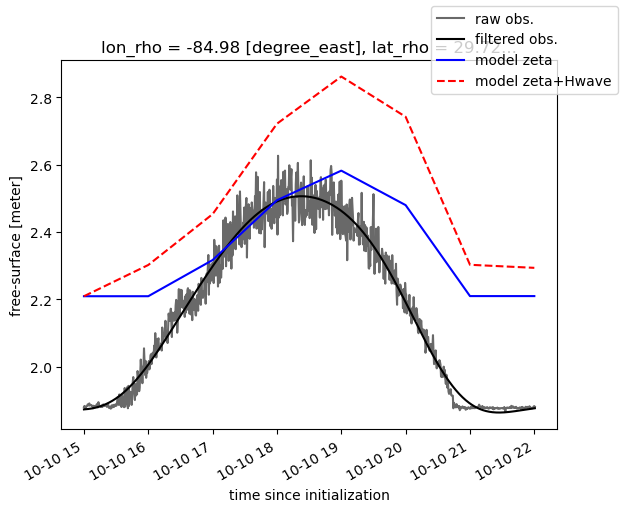

In [74]:
dstart = '2018-10-10 15:00'
dend = '2018-10-10 22:00'

zw = dsm['zeta'].sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).values + dsm['Hwave'].sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).values
t = dsm['ocean_time'].sel(ocean_time=slice(dstart,dend))

fig, ax = plt.subplots(ncols=1)
ds[hraw].sel(time=slice(dstart,dend)).plot(c='dimgray',label='raw obs.')
ds[hf].sel(time=slice(dstart,dend)).plot(c='black',label='filtered obs.')
dsm.zeta.sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).plot(c='blue',label='model zeta')
plt.plot(t,zw,'--r',label='model zeta+Hwave')
fig.legend()


In [62]:
# plotting with hvplot
a=ds[hraw].hvplot(x='time',c='dimgray',label='raw obs.')
b=ds[hf].hvplot(x='time',c='black',label='filtered obs.')
c = dsm.zeta.sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).hvplot(x='ocean_time', c='blue',label='model')
d = dsm.Hwave.sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).hvplot(x='ocean_time', c='red',label='waves')

a*b*c*d

:Overlay
   .Curve.Raw_obs_full_stop      :Curve   [time]   (unfiltered_water_surface_height_above_reference_datum)
   .Curve.Filtered_obs_full_stop :Curve   [time]   (water_surface_height_above_reference_datum)
   .Curve.Model                  :Curve   [ocean_time]   (zeta)
   .Curve.Waves                  :Curve   [ocean_time]   (Hwave)

In [71]:
# trying to sum these
zw = dsm['zeta'].sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).values + dsm['Hwave'].sel(ocean_time=slice(dstart,dend)).xroms.sel2d(lon, lat).values
zw

array([2.2091925, 2.3020043, 2.4530725, 2.7215447, 2.861678 , 2.7421072,
       2.302569 , 2.2935092], dtype=float32)

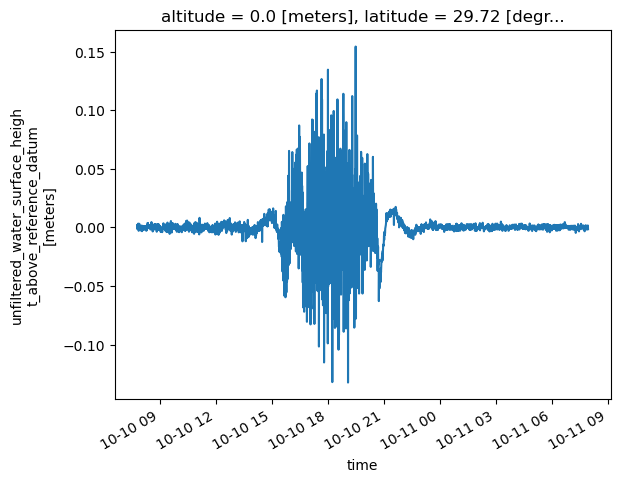

In [20]:
# example of plotting the difference
(ds[hr]-ds[hf]).plot()